# Recommendation System Models Evaluation

This notebook is used to test with differen tmodels with different parameters to find the best model for the recommendation system.
It is sued as a test not as an evaluation script. This notebook also provides visualizton of the results.

In [1]:
# Standard library imports
import os
import datetime
import pickle
import time
from glob import glob
from typing import Dict, List, Optional, Set, Tuple

# Third party imports
import numpy as np
import pandas as pd
import implicit
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csr_matrix, vstack
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Local imports
from Utils.utils import visualize_bought, visualize_candidates
from Models.numerical_CBF import NumericalCBF
from Models.hybrid import HybridRecommender
from Models.collaborative_filtering import ALSRecommender, SVDRecommender

# Settings
os.environ['OPENBLAS_NUM_THREADS'] = '1' # Prevents OpenBLAS from using multiple threads
pd.set_option('display.max_columns', 500)

In [2]:
# Load data
customers = pd.read_pickle("data/customers.pkl")
articles = pd.read_pickle("data/articles.pkl")
transactions = pd.read_pickle("data/transactions.pkl")

In [3]:
images = glob("data/images/*/*", recursive=True)
image_ids = pd.DataFrame([{'image_id': image.split('/')[-1].split('.')[0], 'path': image} for image in images])

In [4]:
print("All Transactions Date Range: {} to {}".format(transactions['t_dat'].min(), transactions['t_dat'].max()))

transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])

train = transactions.loc[(transactions["t_dat"] >= transactions["t_dat"].min()) & (transactions['t_dat'] < datetime.datetime(2020,9,16))]
val = transactions.loc[transactions["t_dat"] >= datetime.datetime(2020,9,16)]

All Transactions Date Range: 2018-09-20 00:00:00 to 2020-09-22 00:00:00


In [5]:
train_purchases = train.groupby('customer_id')['article_id'].agg(list).reset_index()
val_purchases = val.groupby('customer_id')['article_id'].agg(list).reset_index()

# Get users present in both sets
common_users = set(train_purchases['customer_id']) & set(val_purchases['customer_id'])

# Filter data for common users
train_filtered = train_purchases[train_purchases['customer_id'].isin(common_users)].reset_index(drop=True)
val_filtered = val_purchases[val_purchases['customer_id'].isin(common_users)].reset_index(drop=True)

In [6]:
articles.head(3)

,article_id,product_type_no,product_type_name,product_group_name,garment_group_no,garment_group_name,colour_group_code,colour_group_name,section_no,section_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,detail_desc
0,0108775015,253,Vest top,Garment Upper body,1002,Jersey Basic,9,Black,16,Womens Everyday Basics,4,Dark,5,Black,Jersey top with narrow shoulder straps.
1,0108775044,253,Vest top,Garment Upper body,1002,Jersey Basic,10,White,16,Womens Everyday Basics,3,Light,9,White,Jersey top with narrow shoulder straps.
2,0108775051,253,Vest top,Garment Upper body,1002,Jersey Basic,11,Off White,16,Womens Everyday Basics,1,Dusty Light,9,White,Jersey top with narrow shoulder straps.


In [7]:
articles.columns

Index(['article_id', 'product_type_no', 'product_type_name',
       'product_group_name', 'garment_group_no', 'garment_group_name',
       'colour_group_code', 'colour_group_name', 'section_no', 'section_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'detail_desc'],
      dtype='object')

In [8]:
import torch
torch.cuda.empty_cache()

In [9]:
import torch

if os.path.exists("Weights/numerical_cbf_recommender.pkl"):
    recommender = NumericalCBF.load("Weights/numerical_cbf_recommender.pkl")
else:
    recommender = NumericalCBF(output_dir='recommendations', device="cuda", batch_size=16)
    recommender.fit(train, customers, articles)
    recommender.save("Weights/numerical_cbf_recommender.pkl")

In [10]:
if os.path.exists("Weights_old/hybrid_recommender.pkl"):
    recommender = HybridRecommender.load("Weights_old/hybrid_recommender.pkl")
else:
    recommender = HybridRecommender(
        alpha=0.5,
        als_params={
            'factors': 100,
            'regularization': 0.01,
            'alpha': 40,
            'iterations': 2
        },
        cbf_params={
            'batch_size': 256
        }
    )
    
    recommender.fit(train, customers, articles)
    recommender.save("Weights/hybrid_recommender.pkl")

In [ ]:
# If model weights are already saved, load them
if os.path.exists("Weights/als_recommender.pkl"):
    recommender = ALSRecommender.load("Weights/als_recommender.pkl")
else:
    recommender = ALSRecommender(
        factors=100,
        regularization=0.01,
        alpha=40,
        iterations=15,
        num_threads=8,
        use_gpu=False
    )
    
    recommender.fit(train, customers, articles)
    recommender.save("Weights/als_recommender.pkl")

In [18]:
# If model weights are already saved, load them
if os.path.exists("Weights/svd_recommender.pkl"):
    recommender = SVDRecommender.load("Weights/svd_recommender.pkl")
else:
    recommender = SVDRecommender(
		factors=100,
	)
    
    recommender.fit(train, customers, articles)
    recommender.save("Weights/svd_recommender.pkl")

In [11]:
user_id = list(common_users)[1]
user_ids = list(common_users)

In [12]:
candidates = recommender.batch_recommend_items(user_ids, n_items=100, filter_already_purchased=True)

AttributeError: 'HybridRecommender' object has no attribute 'batch_recommend_items'

In [19]:
user_id = 'c534ca9f4e77e9161b628e8daa0a9da6b37feec374b61db7b3815849432201d6'
candidates = recommender.recommend_items(user_id, n_items=100, filter_already_purchased=True)

In [20]:
candidates

[('0573937001', 0.16682240105344143),
 ('0652924004', 0.124739967114145),
 ('0294008002', 0.11772017816062447),
 ('0779554002', 0.10003388009464824),
 ('0537116001', 0.09846108941787789),
 ('0685347001', 0.0867887630618452),
 ('0779551002', 0.08195129189662433),
 ('0788261001', 0.08145637514084726),
 ('0778064001', 0.08108593632659104),
 ('0554479001', 0.07768786408963457),
 ('0751551001', 0.07172390832336398),
 ('0536139006', 0.06869317381564304),
 ('0750330002', 0.06796006504166419),
 ('0652924010', 0.06563334872843336),
 ('0719655001', 0.0609699028258027),
 ('0624257001', 0.05993726812333599),
 ('0768912001', 0.05927595081152953),
 ('0742274001', 0.059122595838521065),
 ('0698387001', 0.05187439338750887),
 ('0803757001', 0.05175850920144846),
 ('0554479005', 0.0478225038867452),
 ('0624251002', 0.04707515097058641),
 ('0750330003', 0.04593898065250276),
 ('0640542002', 0.045828637163725885),
 ('0179123001', 0.04548045365614526),
 ('0678942001', 0.04343880546686522),
 ('0294008005',

In [21]:
candidates = pd.DataFrame(candidates, columns=['article_id', 'score'])
candidates = candidates.merge(articles, on='article_id', how='left')
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   article_id                    100 non-null    object  
 1   score                         100 non-null    float64 
 2   product_type_no               100 non-null    int16   
 3   product_type_name             100 non-null    category
 4   product_group_name            100 non-null    category
 5   garment_group_no              100 non-null    int16   
 6   garment_group_name            100 non-null    category
 7   colour_group_code             100 non-null    int16   
 8   colour_group_name             100 non-null    category
 9   section_no                    100 non-null    int16   
 10  section_name                  100 non-null    category
 11  perceived_colour_value_id     100 non-null    int16   
 12  perceived_colour_value_name   100 non-null    categ

In [22]:
candidates.columns

Index(['article_id', 'score', 'product_type_no', 'product_type_name',
       'product_group_name', 'garment_group_no', 'garment_group_name',
       'colour_group_code', 'colour_group_name', 'section_no', 'section_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'detail_desc'],
      dtype='object')

User's historical interactions:


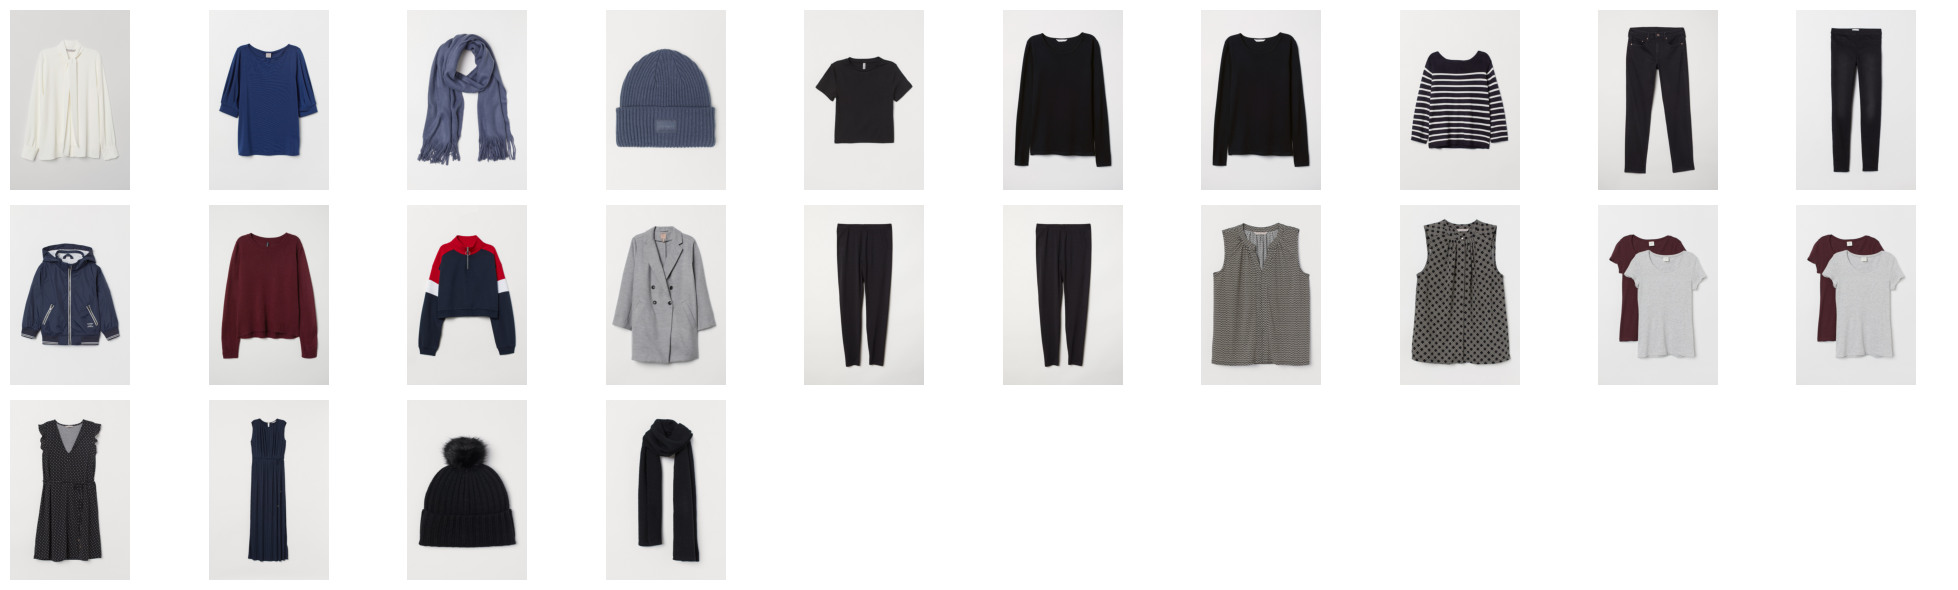

Val User's historical interactions:


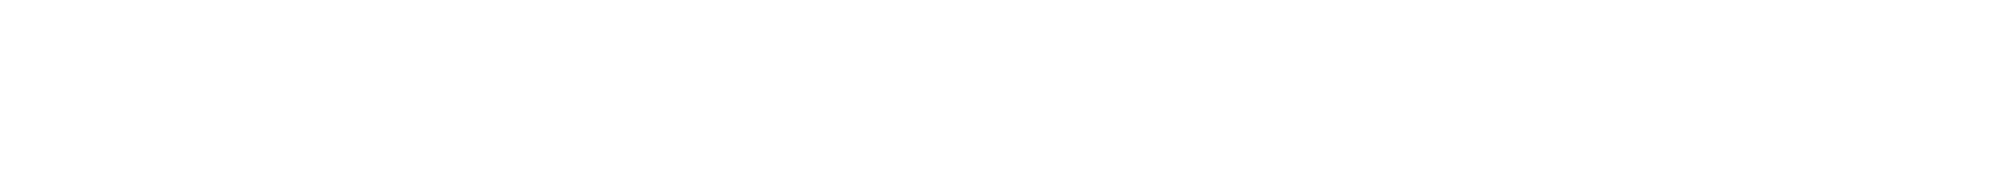

Candidates:


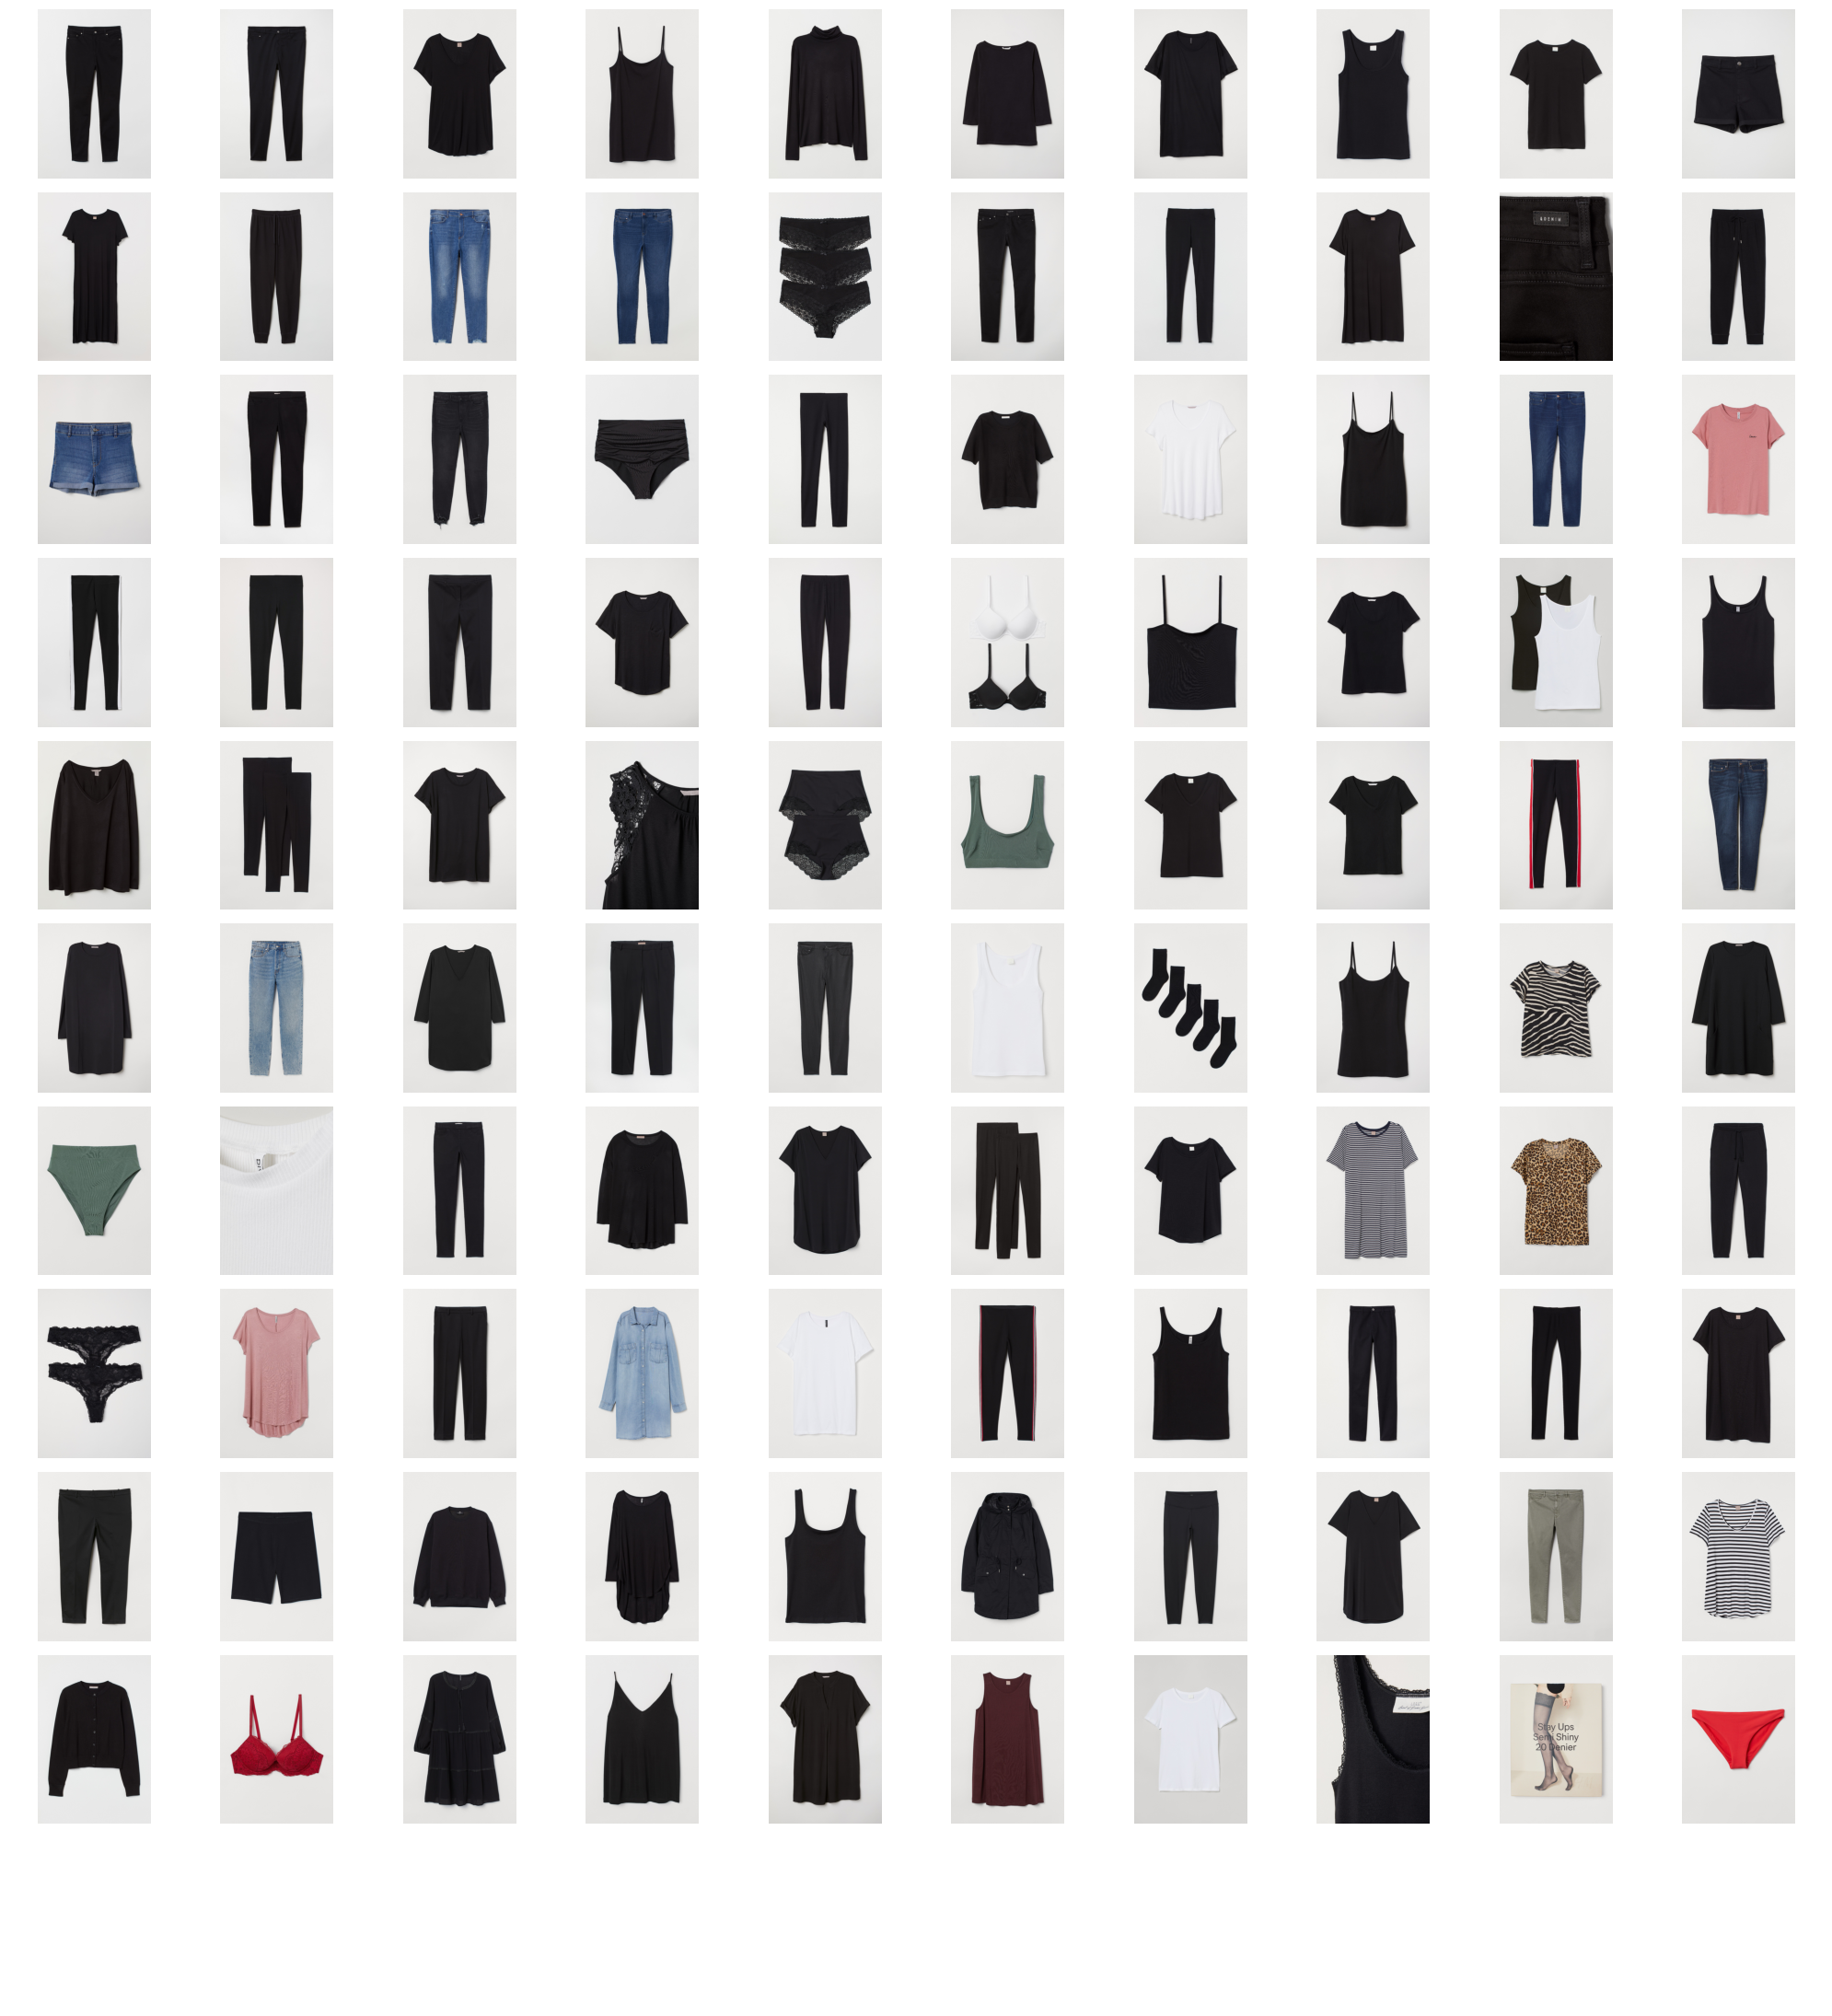

In [23]:
print("User's historical interactions:")
visualize_bought(user_id, train, image_ids)
print("Val User's historical interactions:")
visualize_bought(user_id, val, image_ids)
print("Candidates:")
visualize_candidates(candidates, image_ids)

In [ ]:
#

In [ ]:
import numpy as np
import time
from tqdm import tqdm

def calculate_recall_at_k(actual, predicted, k):
    """Calculate Recall@K for single user"""
    if len(actual) == 0:
        return 0.0
        
    # Only consider top k predictions
    predicted = predicted[:k]
    
    # Calculate intersection of actual and predicted
    num_hits = len(set(actual) & set(predicted))
    
    return num_hits / len(actual)

def calculate_coverage(all_candidates, catalog_items):
    """Calculate catalog coverage"""
    # Get unique items from all predictions
    predicted_items = set()
    for candidates in all_candidates:
        predicted_items.update(candidates)
        
    # Calculate coverage
    coverage = len(predicted_items) / len(catalog_items)
    
    return coverage

def calculate_diversity(all_candidates, item_features):
    """Calculate recommendation diversity"""
    if not item_features:
        return 0.0
        
    diversities = []
    
    for candidates in all_candidates:
        pair_diversities = []
        
        for i in range(len(candidates)):
            for j in range(i + 1, len(candidates)):
                item1, item2 = candidates[i], candidates[j]
                
                if item1 in item_features and item2 in item_features:
                    # Calculate cosine similarity
                    sim = np.dot(item_features[item1], item_features[item2])
                    sim /= (np.linalg.norm(item_features[item1]) * 
                           np.linalg.norm(item_features[item2]))
                    # Convert to diversity
                    pair_diversities.append(1 - sim)
                    
        if pair_diversities:
            diversities.append(np.mean(pair_diversities))
            
    return np.mean(diversities) if diversities else 0.0

def evaluate_model(
    model,
    users,
    items,
    purchases,
    k=10,
    item_features=None
):
    """
    Evaluate recommendation model
    
    Args:
        model: Recommendation model with recommend_items method
        users: List of user IDs
        items: Dictionary of item information
        purchases: Dictionary of user purchase history
        k: Number of recommendations to evaluate
        item_features: Optional dictionary of item features for diversity
    
    Returns:
        Dictionary of evaluation metrics
    """
    start = time.time()
    recalls = []
    all_candidates = []
    
    print("Evaluating model recommendations...")
    for user in tqdm(users):
        # Get user's purchases
        actual = purchases[user]
        
        # Get model's recommendations
        candidates = model.recommend_items(user, n_items=k)
        predicted = [c[0] for c in candidates]  # Assuming candidates are (item_id, score) tuples
        all_candidates.append(predicted)
        
        # Calculate Recall@K
        recall = calculate_recall_at_k(actual, predicted, k)
        recalls.append(recall)
    
    # Calculate metrics
    recall = np.mean(recalls)
    coverage = calculate_coverage(all_candidates, set(items.keys()))
    
    metrics = {
        f'Recall@{k}': recall,
        'Catalog Coverage': coverage,
    }
    
    # Add diversity if item features provided
    if item_features is not None:
        diversity = calculate_diversity(all_candidates, item_features)
        metrics['Diversity'] = diversity
    
    elapsed = time.time() - start
    metrics['Elapsed Time'] = elapsed
    
    print(f"Evaluated model in {elapsed:.2f} seconds")
    for metric, value in metrics.items():
        if metric != 'Elapsed Time':
            print(f"{metric}: {value:.4f}")
    
    return metrics

# Example usage:
model = recommender
users = list(common_users)
items = dict(articles['article_id'])
purchases = val_filtered.set_index('customer_id')['article_id'].to_dict()
item_features = None

metrics = evaluate_model(
    model=model,
    users=users,
    items=items,
    purchases=purchases,
    k=100,
    item_features=item_features
)


In [ ]:
metrics